# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning II</font>

## Mini-Projeto 1 - Previsões com Séries Temporais e RNNs 

## Introdução

Neste mini-projeto, você realizará uma previsão de séries temporais usando um regressor com Rede Neural Recorrente. Usaremos dados reais para prever os futuros preços das ações da Apple usando um modelo RNN.

## Carregando os Dados

Primeiro, devemos carregar nossas séries temporais - uma série histórica de cerca de 140 dias do preço das ações da Apple (extraído do site DataMarket - https://datamarket.com/data/list/?q=provider%3Atsdl). Em seguida, precisamos executar uma série de etapas de pré-processamento para preparar os dados para uso com um modelo RNN. 

É uma boa prática normalizar as séries temporais - normalizando seu range. Isso nos ajuda a evitar problemas numéricos sérios associados a funções de ativação comuns (como o tanh) que transformam números muito grandes (positivos ou negativos), além de ajudar a evitar problemas relacionados ao computar derivadas.

Aqui nós normalizamos a série para ficar na faixa [0,1], mas é também é comum normalizar por um desvio padrão da série.

In [1]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
import keras as k
k.__version__

Using TensorFlow backend.


'2.3.1'

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
%matplotlib inline

In [4]:
dataset = np.loadtxt('datasets/normalized_apple_prices.csv')

Text(0, 0.5, 'Valores Normalizados da Série')

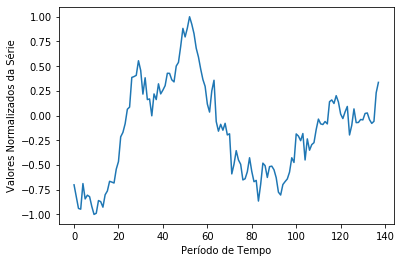

In [5]:
# Plot
plt.plot(dataset)
plt.xlabel('Período de Tempo')
plt.ylabel('Valores Normalizados da Série')

## Extraindo Sequências da Série Temporal

Lembre-se, nossa série de tempo é uma sequência de números que podemos representar em termos matemáticos, como:

$$s_{0},s_{1},s_{2},...,s_{P}$$

onde $ s_ {p} $ é o valor numérico das séries temporais no período de tempo $ p $ e onde $ P $ é o comprimento total da série. Para aplicar nossa RNN tratamos o problema de previsão de séries temporais como um problema de regressão e, portanto, precisamos usar uma janela deslizante para construir um conjunto de pares de entrada / saída associados para regredir. Este processo é representado no gif abaixo.

<img src="images/timeseries_windowing_training.gif" width=600 height=600/>

Por exemplo - usando uma janela de tamanho T = 5 (como ilustrado no gif acima) produzimos um conjunto de pares de entrada / saída como o mostrado na tabela abaixo

$$
\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Observe aqui que cada entrada é uma sequência (ou vetor) de comprimento 4 (e em geral tem um comprimento igual ao tamanho da janela T), enquanto cada saída correspondente é um valor escalar. Observe também como é dada uma série de tempo de comprimento P e tamanho de janela T = 5 como mostrado acima, criamos pares de entrada / saída P-5. De forma mais geral, para um tamanho de janela T, criamos P-T desses pares.

Abaixo, temos uma função que cria essa janela deslizante.

In [6]:
# Função que transforma séries e window-size em um conjunto de input/output para o modelo RNN 
def window_transform_series(series, window_size):
    """
      Argumentos:
        series(np.array(list)): Sequência de valores
        window_size(int      ): Tamanho da janela
      
      Retorna:
         X(np.array(list(list))): Matriz de Input
         y(np.array(list))      : Array de Ouput
    """

    # Objetos para input/output 
    X = np.asarray([series[i:(i + window_size)] for i in range(len(series) - window_size)])
    y = np.asarray([series[i + window_size] for i in range(len(series) - window_size)])

    return X,y

Aplicamos a função ao nosso conjunto de dados e definimos um windows-size = 7.

In [7]:
window_size = 7
X,y = window_transform_series(series = dataset, window_size = window_size)

In [8]:
X

array([[-0.70062339, -0.82088484, -0.93938305, -0.9471652 , -0.68785527,
        -0.84325902, -0.80532018],
       [-0.82088484, -0.93938305, -0.9471652 , -0.68785527, -0.84325902,
        -0.80532018, -0.82058073],
       [-0.93938305, -0.9471652 , -0.68785527, -0.84325902, -0.80532018,
        -0.82058073, -0.92023124],
       [-0.9471652 , -0.68785527, -0.84325902, -0.80532018, -0.82058073,
        -0.92023124, -1.        ],
       [-0.68785527, -0.84325902, -0.80532018, -0.82058073, -0.92023124,
        -1.        , -0.98814438],
       [-0.84325902, -0.80532018, -0.82058073, -0.92023124, -1.        ,
        -0.98814438, -0.85961411],
       [-0.80532018, -0.82058073, -0.92023124, -1.        , -0.98814438,
        -0.85961411, -0.8706188 ],
       [-0.82058073, -0.92023124, -1.        , -0.98814438, -0.85961411,
        -0.8706188 , -0.92661512],
       [-0.92023124, -1.        , -0.98814438, -0.85961411, -0.8706188 ,
        -0.92661512, -0.80118585],
       [-1.        , -0.9881

## Dados de Treino e de Teste

Para realizar testes adequados em nosso conjunto de dados, usaremos o último 1/3 dele para teste. Isto é, uma vez que treinamos nosso modelo, temos algo para testá-lo (como qualquer problema de regressão!). Esta divisão em conjuntos de treinamento/teste é feita na célula abaixo.

Observe como aqui ** não ** estamos dividindo o conjunto de dados * aleatoriamente * como normalmente seria feito ao validar um modelo de regressão. Isso ocorre porque nossos pares de entrada/saída * estão relacionados temporariamente *. Não queremos validar o nosso modelo treinando em um subconjunto aleatório da série e depois testar em outro subconjunto aleatório.

Queremos treinar em um pedaço sólido da série (no nosso caso, os primeiros 2/3 completos), e validar em um pedaço posterior (o último 1/3), pois isso simula como prevermos os valores do * futuro * de uma série temporal.

In [9]:
# Split em treino e teste
train_test_split = int(np.ceil(2*len(y)/float(3)))  # Ponto de split

# Particiona os dados de treino em X e Y
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# Particiona os dados de teste em X e Y
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# Para criar o Modelo RNN LSTM com o Keras nossos dados precisam estar no formato [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

In [10]:
X_train.shape

(88, 7, 1)

## Construindo o Modelo RNN

Tendo criado pares de entrada / saída de nossas séries temporais e dividido em conjuntos de treinamento / teste, agora podemos começar a configurar nossa RNN. Usamos o Keras para criar rapidamente uma RNN de duas camadas ocultas com as  seguintes especificações

- A camada 1 usa um módulo LSTM com 5 unidades escondidas (observe aqui o input_shape = (window_size, 1))
- A camada 2 usa um módulo totalmente conectado com uma unidade
- A perda 'mean_squared_error' deve ser usada (lembre-se: estamos realizando regressão aqui)

In [11]:
# RNN para regressão em nossos dados de séries temporais 
def build_RNN(window_size):
    model = Sequential()
    model.add(LSTM(5, input_shape=(window_size,1)))
    model.add(Dense(1))
    return model

In [12]:
# Cria e compila o modelo
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

# Random seed
np.random.seed(0)

# Build do modelo
model = build_RNN(window_size)

# Otimizador
optimizer = keras.optimizers.RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-08, decay = 0.0)

# Compila o modelo
model.compile(loss = 'mean_squared_error', optimizer = optimizer)

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


Fit do modelo

In [14]:
model.fit(X_train, y_train, epochs = 1000, batch_size = 50, verbose = 1)

Epoch 1/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.1356
Epoch 2/1000
88/88 [==============================] - 0s 112us/step - loss: 0.1275
Epoch 3/1000
88/88 [==============================] - 0s 107us/step - loss: 0.1221
Epoch 4/1000
88/88 [==============================] - 0s 98us/step - loss: 0.1176
Epoch 5/1000
88/88 [==============================] - 0s 106us/step - loss: 0.1136
Epoch 6/1000
88/88 [==============================] - 0s 105us/step - loss: 0.1099
Epoch 7/1000
88/88 [==============================] - 0s 99us/step - loss: 0.1067
Epoch 8/1000
88/88 [==============================] - 0s 87us/step - loss: 0.1035
Epoch 9/1000
88/88 [==============================] - 0s 74us/step - loss: 0.1007
Epoch 10/1000
88/88 [==============================] - 0s 81us/step - loss: 0.0979
Epoch 11/1000
88/88 [==============================] - 0s 77us/step - loss: 0.0950
Epoch 12/1000
88/88 [==============================] - 0s 70us/step - loss: 0.0923
Epoch 13/1

88/88 [==============================] - 0s 59us/step - loss: 0.0360
Epoch 100/1000
88/88 [==============================] - 0s 66us/step - loss: 0.0356
Epoch 101/1000
88/88 [==============================] - 0s 66us/step - loss: 0.0355
Epoch 102/1000
88/88 [==============================] - 0s 62us/step - loss: 0.0353
Epoch 103/1000
88/88 [==============================] - 0s 66us/step - loss: 0.0352
Epoch 104/1000
88/88 [==============================] - 0s 65us/step - loss: 0.0350
Epoch 105/1000
88/88 [==============================] - 0s 67us/step - loss: 0.0348
Epoch 106/1000
88/88 [==============================] - 0s 81us/step - loss: 0.0346
Epoch 107/1000
88/88 [==============================] - 0s 72us/step - loss: 0.0346
Epoch 108/1000
88/88 [==============================] - 0s 76us/step - loss: 0.0344
Epoch 109/1000
88/88 [==============================] - 0s 62us/step - loss: 0.0341
Epoch 110/1000
88/88 [==============================] - 0s 71us/step - loss: 0.0341
Epoch 1

88/88 [==============================] - 0s 66us/step - loss: 0.0219
Epoch 197/1000
88/88 [==============================] - 0s 64us/step - loss: 0.0217
Epoch 198/1000
88/88 [==============================] - 0s 66us/step - loss: 0.0217
Epoch 199/1000
88/88 [==============================] - 0s 66us/step - loss: 0.0216
Epoch 200/1000
88/88 [==============================] - 0s 63us/step - loss: 0.0214
Epoch 201/1000
88/88 [==============================] - 0s 64us/step - loss: 0.0214
Epoch 202/1000
88/88 [==============================] - 0s 64us/step - loss: 0.0212
Epoch 203/1000
88/88 [==============================] - 0s 67us/step - loss: 0.0213
Epoch 204/1000
88/88 [==============================] - 0s 68us/step - loss: 0.0211
Epoch 205/1000
88/88 [==============================] - 0s 60us/step - loss: 0.0211
Epoch 206/1000
88/88 [==============================] - 0s 68us/step - loss: 0.0210
Epoch 207/1000
88/88 [==============================] - 0s 64us/step - loss: 0.0207
Epoch 2

88/88 [==============================] - 0s 62us/step - loss: 0.0176
Epoch 294/1000
88/88 [==============================] - 0s 63us/step - loss: 0.0176
Epoch 295/1000
88/88 [==============================] - 0s 58us/step - loss: 0.0176
Epoch 296/1000
88/88 [==============================] - 0s 67us/step - loss: 0.0178
Epoch 297/1000
88/88 [==============================] - 0s 67us/step - loss: 0.0176
Epoch 298/1000
88/88 [==============================] - 0s 65us/step - loss: 0.0176
Epoch 299/1000
88/88 [==============================] - 0s 62us/step - loss: 0.0175
Epoch 300/1000
88/88 [==============================] - 0s 60us/step - loss: 0.0175
Epoch 301/1000
88/88 [==============================] - 0s 63us/step - loss: 0.0176
Epoch 302/1000
88/88 [==============================] - 0s 62us/step - loss: 0.0175
Epoch 303/1000
88/88 [==============================] - 0s 59us/step - loss: 0.0177
Epoch 304/1000
88/88 [==============================] - 0s 69us/step - loss: 0.0174
Epoch 3

88/88 [==============================] - 0s 70us/step - loss: 0.0169
Epoch 391/1000
88/88 [==============================] - 0s 69us/step - loss: 0.0172
Epoch 392/1000
88/88 [==============================] - 0s 61us/step - loss: 0.0169
Epoch 393/1000
88/88 [==============================] - 0s 63us/step - loss: 0.0170
Epoch 394/1000
88/88 [==============================] - 0s 59us/step - loss: 0.0170
Epoch 395/1000
88/88 [==============================] - 0s 59us/step - loss: 0.0171
Epoch 396/1000
88/88 [==============================] - 0s 63us/step - loss: 0.0170
Epoch 397/1000
88/88 [==============================] - 0s 59us/step - loss: 0.0170
Epoch 398/1000
88/88 [==============================] - 0s 59us/step - loss: 0.0170
Epoch 399/1000
88/88 [==============================] - 0s 64us/step - loss: 0.0169
Epoch 400/1000
88/88 [==============================] - 0s 60us/step - loss: 0.0172
Epoch 401/1000
88/88 [==============================] - 0s 64us/step - loss: 0.0169
Epoch 4

88/88 [==============================] - 0s 70us/step - loss: 0.0168
Epoch 488/1000
88/88 [==============================] - 0s 77us/step - loss: 0.0168
Epoch 489/1000
88/88 [==============================] - 0s 73us/step - loss: 0.0168
Epoch 490/1000
88/88 [==============================] - 0s 75us/step - loss: 0.0168
Epoch 491/1000
88/88 [==============================] - 0s 62us/step - loss: 0.0168
Epoch 492/1000
88/88 [==============================] - 0s 60us/step - loss: 0.0167
Epoch 493/1000
88/88 [==============================] - 0s 67us/step - loss: 0.0173
Epoch 494/1000
88/88 [==============================] - 0s 58us/step - loss: 0.0170
Epoch 495/1000
88/88 [==============================] - 0s 63us/step - loss: 0.0167
Epoch 496/1000
88/88 [==============================] - 0s 71us/step - loss: 0.0167
Epoch 497/1000
88/88 [==============================] - 0s 58us/step - loss: 0.0169
Epoch 498/1000
88/88 [==============================] - 0s 70us/step - loss: 0.0167
Epoch 4

88/88 [==============================] - 0s 64us/step - loss: 0.0166
Epoch 585/1000
88/88 [==============================] - 0s 66us/step - loss: 0.0167
Epoch 586/1000
88/88 [==============================] - 0s 66us/step - loss: 0.0168
Epoch 587/1000
88/88 [==============================] - 0s 71us/step - loss: 0.0166
Epoch 588/1000
88/88 [==============================] - 0s 71us/step - loss: 0.0168
Epoch 589/1000
88/88 [==============================] - 0s 74us/step - loss: 0.0167
Epoch 590/1000
88/88 [==============================] - 0s 90us/step - loss: 0.0168
Epoch 591/1000
88/88 [==============================] - 0s 64us/step - loss: 0.0167
Epoch 592/1000
88/88 [==============================] - 0s 67us/step - loss: 0.0167
Epoch 593/1000
88/88 [==============================] - 0s 63us/step - loss: 0.0166
Epoch 594/1000
88/88 [==============================] - 0s 64us/step - loss: 0.0170
Epoch 595/1000
88/88 [==============================] - 0s 67us/step - loss: 0.0167
Epoch 5

88/88 [==============================] - 0s 64us/step - loss: 0.0169
Epoch 682/1000
88/88 [==============================] - 0s 62us/step - loss: 0.0167
Epoch 683/1000
88/88 [==============================] - 0s 67us/step - loss: 0.0167
Epoch 684/1000
88/88 [==============================] - 0s 61us/step - loss: 0.0166
Epoch 685/1000
88/88 [==============================] - 0s 66us/step - loss: 0.0168
Epoch 686/1000
88/88 [==============================] - 0s 65us/step - loss: 0.0166
Epoch 687/1000
88/88 [==============================] - 0s 62us/step - loss: 0.0165
Epoch 688/1000
88/88 [==============================] - 0s 72us/step - loss: 0.0166
Epoch 689/1000
88/88 [==============================] - 0s 68us/step - loss: 0.0166
Epoch 690/1000
88/88 [==============================] - 0s 63us/step - loss: 0.0166
Epoch 691/1000
88/88 [==============================] - 0s 68us/step - loss: 0.0165
Epoch 692/1000
88/88 [==============================] - 0s 62us/step - loss: 0.0166
Epoch 6

88/88 [==============================] - 0s 65us/step - loss: 0.0165
Epoch 779/1000
88/88 [==============================] - 0s 66us/step - loss: 0.0165
Epoch 780/1000
88/88 [==============================] - 0s 66us/step - loss: 0.0164
Epoch 781/1000
88/88 [==============================] - 0s 69us/step - loss: 0.0164
Epoch 782/1000
88/88 [==============================] - 0s 61us/step - loss: 0.0165
Epoch 783/1000
88/88 [==============================] - 0s 64us/step - loss: 0.0165
Epoch 784/1000
88/88 [==============================] - 0s 62us/step - loss: 0.0168
Epoch 785/1000
88/88 [==============================] - 0s 67us/step - loss: 0.0169
Epoch 786/1000
88/88 [==============================] - 0s 69us/step - loss: 0.0164
Epoch 787/1000
88/88 [==============================] - 0s 67us/step - loss: 0.0168
Epoch 788/1000
88/88 [==============================] - 0s 63us/step - loss: 0.0165
Epoch 789/1000
88/88 [==============================] - 0s 61us/step - loss: 0.0165
Epoch 7

88/88 [==============================] - 0s 66us/step - loss: 0.0166
Epoch 876/1000
88/88 [==============================] - 0s 59us/step - loss: 0.0165
Epoch 877/1000
88/88 [==============================] - 0s 70us/step - loss: 0.0164
Epoch 878/1000
88/88 [==============================] - 0s 67us/step - loss: 0.0170
Epoch 879/1000
88/88 [==============================] - 0s 72us/step - loss: 0.0164
Epoch 880/1000
88/88 [==============================] - 0s 65us/step - loss: 0.0166
Epoch 881/1000
88/88 [==============================] - 0s 63us/step - loss: 0.0165
Epoch 882/1000
88/88 [==============================] - 0s 69us/step - loss: 0.0164
Epoch 883/1000
88/88 [==============================] - 0s 61us/step - loss: 0.0164
Epoch 884/1000
88/88 [==============================] - 0s 68us/step - loss: 0.0164
Epoch 885/1000
88/88 [==============================] - 0s 67us/step - loss: 0.0164
Epoch 886/1000
88/88 [==============================] - 0s 61us/step - loss: 0.0165
Epoch 8

88/88 [==============================] - 0s 62us/step - loss: 0.0164
Epoch 973/1000
88/88 [==============================] - 0s 68us/step - loss: 0.0163
Epoch 974/1000
88/88 [==============================] - 0s 66us/step - loss: 0.0165
Epoch 975/1000
88/88 [==============================] - 0s 58us/step - loss: 0.0164
Epoch 976/1000
88/88 [==============================] - 0s 66us/step - loss: 0.0163
Epoch 977/1000
88/88 [==============================] - 0s 65us/step - loss: 0.0166
Epoch 978/1000
88/88 [==============================] - 0s 62us/step - loss: 0.0165
Epoch 979/1000
88/88 [==============================] - 0s 62us/step - loss: 0.0164
Epoch 980/1000
88/88 [==============================] - 0s 68us/step - loss: 0.0169
Epoch 981/1000
88/88 [==============================] - 0s 67us/step - loss: 0.0167
Epoch 982/1000
88/88 [==============================] - 0s 63us/step - loss: 0.0164
Epoch 983/1000
88/88 [==============================] - 0s 63us/step - loss: 0.0163
Epoch 9

In [15]:
X_train.shape

(88, 7, 1)

## Avalia a Performance do Modelo

In [16]:
# Greando previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [17]:
# Print dos erros de treino e de teste
training_error = model.evaluate(X_train, y_train, verbose=0)
print('Erro em Treinamento = %.3f %%' % training_error)

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('Erro em Teste = %.3f %%' %  testing_error)

Erro em Treinamento = 0.016 %
Erro em Teste = 0.014 %


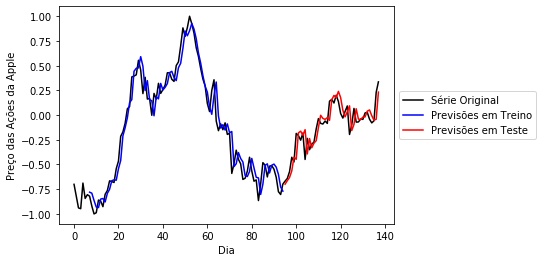

In [18]:
# Plot
import matplotlib.pyplot as plt
%matplotlib inline

# Plot da série original
plt.plot(dataset,color = 'k')

# Plot das previsões em treino
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot das previsões em treino
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# Plot
plt.xlabel('Dia')
plt.ylabel('Preço das Ações da Apple')
plt.legend(['Série Original','Previsões em Treino','Previsões em Teste'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Fim